### 기존의 흐름(→Neo4j 단독, →VectorDB 단독, 두 개 병렬) + “Neo4j → VectorDB 순차 호출” 추가

In [24]:
from typing import Annotated, List, TypedDict, Dict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI
from transformers import AutoTokenizer, AutoModelForCausalLM
import os, json, re
import asyncio
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings

load_dotenv()
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model_client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
model = ChatOpenAI(temperature=0.2,
                    model_name="gpt-4o")
# tokenizer = AutoTokenizer.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model = AutoModelForCausalLM.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model.to(device)


In [25]:
# langgraph state 정의
from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages, AnyMessage

class ChatbotState(TypedDict):
    """
    RAG 챗봇의 상태를 관리하는 객체입니다.

    Attributes:
        question: 사용자의 원본 질문
        flow_type: 라우터 에이전트가 결정한 데이터 조회 흐름 (sequential, parallel, neo4j_only, vector_db_only)
        patient_info: 순차 흐름 시 Neo4j에서 추출하여 VectorDB 검색에 활용할 환자 정보
        decision_slack: 슬랙 메시지 전송 여부 ('Yes' 또는 'No')
        tools_query: 각 DB로 전달될 쿼리 리스트 [neo4j_query, vector_db_query]
        neo4j_documents: Neo4j DB에서 검색된 문서
        vector_documents: Vector DB에서 검색된 문서
        final_answer: LLM이 생성한 최종 답변
        slack_response: 슬랙 전송 결과 메시지
        messages: 대화 기록
    """
    question: Annotated[str, "사용자 원본 질문"]
    flow_type: Annotated[str, "데이터베이스 조회 흐름"]
    patient_info: Annotated[str, "순차 처리를 위한 환자 정보"]
    decision_slack: Annotated[str, "슬랙 전송 여부 결정"]
    tools_query: Annotated[List[str], "각 DB에 전달할 쿼리 리스트"]
    neo4j_documents: Annotated[List, "Neo4j 검색 결과"]
    vector_documents: Annotated[List, "VectorDB 검색 결과"]
    final_answer: Annotated[str, "최종 답변"]
    slack_response: Annotated[str, "슬랙 전송 결과"]
    messages: List[BaseMessage]

memory = MemorySaver()


In [26]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langgraph.prebuilt import ToolNode

# MCP 서버들 불러오기
mcp_client = MultiServerMCPClient(
    {
        "neo4j_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/home/hyewon/boaz/mcp/mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/home/hyewon/boaz/mcp/mcp_vectordb_server.py"],
            "transport": "stdio",
        },
        # Slack MCP 서버 설정
        "slack": {
            "command": "npx",
            "args": [
                "-y",
                "@modelcontextprotocol/server-slack"
            ],
            "transport": "stdio", 
            "env": {
                "SLACK_BOT_TOKEN": os.getenv("SLACK_BOT_TOKEN"),
                "SLACK_TEAM_ID": os.getenv("SLACK_TEAM_ID"),
                # 선택사항: 특정 채널만 접근하려는 경우
                # "SLACK_CHANNEL_IDS": 
            }
        }
    }
)

# MCP 서버 잘 가져왔는지 확인
mcp_tools = await mcp_client.get_tools()
tools_dict = {tool.name: tool for tool in mcp_tools}
print(tools_dict)

# 사용 가능한 모든 MCP 도구를 리스트로 변환 (Slack 도구 포함)
# Agent가 사용할 수 있는 도구 목록
all_mcp_tools = list(tools_dict.values())
print(all_mcp_tools)

{'neo4j_retriever': StructuredTool(name='neo4j_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'neo4j_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x79edb370c040>), 'VectorDB_retriever': StructuredTool(name='VectorDB_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'VectorDB_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x79ec93ee17e0>), 'slack_list_channels': StructuredTool(name='slack_list_channels', description='List public or pre-defined channels in the workspace with pagination', args_schema={'type': 'object', 'properties': {'limit': {'type': 'number', 'description': 'Maximum number of channels to return (default 100, max

In [ ]:
# function_calling_tools = [
#     {
#         "type": "function",
#         "name": "neo4j_retriever",
#         "description": """Use this tool when the user's query is explicitly about patient-specific 
#             clinical information or refers to structured medical records.

#             This includes queries containing terms such as: 
#             '환자', '환자정보', '환자기록', '환자이력', '환자데이터', '환자상태', 
#             '수술이력', '검사기록', '진료기록', '입원', '퇴원', '복용약물',
#             '진단', '수술명', '마취제', '마취제 유형', '수술 전 상태', '수술 후 상태'.

#             These queries typically require retrieving structured data from graph-based 
#             medical records (e.g., Neo4j) related to an individual patient or to specific 
#             clinical procedures.

#             This tool is designed to access and return relevant information such as:
#             surgery history, diagnoses, anesthesia types used, pre- and post-operative conditions, 
#             medication usage, lab results, and hospitalization records.

#             Use this tool when the question involves:
#             - Specific patients
#             - Specific treatments or surgeries
#             - Named diagnoses or procedures
#             - Clinical state before/after operations

#             Do not use this tool for general medical knowledge, non-clinical topics, or 
#             queries unrelated to structured or relational patient data.""",
#         "parameters": {
#             "type": "object",
#             "properties": {
#                 "query": {
#                     "type": "string",
#                     "description": """Please write the query as a natural language question about the patient's clinical records.

#                     The query will be interpreted to explore nodes (e.g., Surgery, Anesthesia, Diagnosis, Patient) and their relationships (e.g., surgeries received by a specific patient) in a graph database.

#                     For example, the question "Tell me the name of the most recent surgery and the anesthesia used" will be processed as a query exploring connections between Surgery and Anesthesia nodes.

#                     Also, the question "Tell me the pre-operative condition and diagnosis of patient Hong Gil-dong" will be interpreted as a query that finds the Person node with the name 'Hong Gil-dong' and extracts the related Pre-op condition and Diagnosis nodes.

#                     If a patient name is specified, please write the query to retrieve not only that patient but also other patients with similar symptoms.

#                     If no patient name is given, please write the query to search for patients matching the symptoms, surgery names, or diagnoses mentioned in the question.

#                     The more specific the patient information or clinical conditions included, the more accurately the relevant data can be retrieved."""
#                 }
#             },
#             "required": ["query"],
#             "additionalProperties": False
#         }
#     },
#     {
#         "type": "function",
#         "name": "VectorDB_retriever",
#         "description": """BrokenPipeErrorUse this tool when the user's query involves general clinical or medical knowledge that is not tied to a specific patient.

#                 This includes queries containing medical or procedural terms such as:
#                 surgery names (e.g., "cholecystectomy", "cardiac surgery"), anesthesia types (e.g., "general anesthesia", "local anesthesia"), medications, clinical processes, or treatment guidelines.

#                 Example queries:
#                 - "How does general anesthesia work?"
#                 - "What are common complications of this surgery?"
#                 - "What anesthetics are typically used in pediatric patients?"

#                 These types of queries are interpreted as requests for background medical knowledge or conceptual explanations. The tool retrieves semantically relevant information from a vector-based medical knowledge database.

#                 Do not use this tool for patient-specific record queries or when structured relational data is needed, such as diagnosis timelines or surgical histories.""",
#         "parameters": {
#             "type": "object",
#             "properties": {
#                 "query": {
#                     "type": "string",
#                     "description": """Construct a query that focuses on general medical or clinical knowledge, excluding any patient-specific details.

#                 The query should be based on concepts extracted from the user's original question, such as surgery names, anesthesia types, diagnoses, medications, or treatment processes.

#                 For example, if the user asks "What kind of anesthesia was used for Kim's surgery?", the query should be reformulated as "What types of anesthesia are commonly used for that kind of surgery?"

#                 Avoid including patient names, identifiers, or individual medical histories. Focus on retrieving background information or typical medical explanations that are generally applicable."""
#                 }
#             },
#             "required": ["query"],
#             "additionalProperties": False
#         }
#     }
# ]

In [ ]:
# # --- 라우터 에이전트용 프롬프트 ---
# ROUTER_PROMPT = """
# 당신은 사용자의 의료 관련 질문을 분석하여 가장 효율적인 데이터베이스 조회 계획을 세우는 전문가입니다. 
# 질문의 내용을 바탕으로 'sequential', 'parallel', 'neo4j_only', 'vector_db_only' 중 하나의 처리 흐름(`flow_type`)을 결정하고, 각 DB에 보낼 쿼리를 생성해야 합니다.

# # 데이터베이스 설명:
# 1.  **Neo4j DB**: 특정 환자의 인적 정보, 진단, 수술 이력, 사용 약물 등 구조화된 환자 기록을 담고 있습니다. '환자', '김민준', '6세 여아' 등 특정인을 지칭하거나 환자 차트(pa_case_reports.csv)에 있을 법한 정보(나이, 성별, 진단명 등)가 포함된 경우 사용합니다.
# 2.  **Vector DB**: 일반적인 의학 논문, 치료 가이드라인, 약물 정보, 수술 절차 등 비구조적인 의학 지식을 담고 있습니다. 의학 용어, 약물 이름, 수술명 등이 직접적으로 언급될 때 사용합니다.

# # 흐름 결정 가이드라인:
# - **sequential**: 질문이 2단계의 정보 조회를 요구할 때 사용합니다.
#     1. 먼저 환자 정보를 **Neo4j DB**에서 찾고 (예: 환자의 수술명, 복용 중인 약물).
#     2. 그 결과로 얻은 정보(예: 특정 약물 이름)를 키워드로 **Vector DB**에서 일반 의학 정보를 찾아야 할 때.
#     - 예시 질문: "6세 여아 폐렴 환자가 받을 수술을 알려주고, 수술에 사용될 마취 약물에 대해 조사해줘."
#     - 이 경우, 먼저 Neo4j에서 '6세 여아 폐렴 환자'의 '수술명'과 '마취 약물'을 찾고, 그 '마취 약물' 이름으로 Vector DB를 검색해야 합니다.
# - **parallel**: 질문이 특정 환자 정보와 일반 의학 정보를 각각 독립적으로 물어볼 때 사용합니다.
#     - 예시 질문: "7세 남아 뇌수종 병을 앓고 있는 환자가 받을 수술을 알려주고, 카사바흐-메리트 증후군이 뭔지도 설명해줘."
# - **neo4j_only**: 질문이 오직 특정 환자의 정보만 요구할 때 사용합니다.
#     - 예시 질문: "환자 APM-14-044의 나이와 병명은?"
# - **vector_db_only**: 질문이 일반적인 의학 지식만 요구할 때 사용합니다.
#     - 예시 질문: "케타민의 부작용은 무엇인가요?"

# # 출력 형식:
# 함수 호출 형식에 맞춰 JSON을 생성하세요. `neo4j_query`와 `vector_db_query`는 해당 흐름에 필요할 때만 생성합니다.
# """

# # --- 순차 흐름에서 VectorDB 쿼리 생성을 위한 프롬프트 ---
# VECTOR_QUERY_GEN_PROMPT = """
# 당신은 사용자의 질문과 환자 데이터를 바탕으로 Vector DB에서 관련 의학 정보를 찾기 위한 최적의 검색어를 생성하는 AI입니다.

# # 사용자 원본 질문:
# {question}

# # 조회된 환자 정보 (Neo4j):
# {patient_info}

# # 지시사항:
# 위 정보를 바탕으로, 사용자가 정말 궁금해할 의학적 사실(예: 의료 지식, 약물 부작용, 수술 주의사항, 질병의 예후 등)을 Vector DB에서 찾을 수 있는 간결하고 명확한 검색어를 1개 생성하세요. 
# 환자 정보에서 핵심적인 의학 용어(수술명, 약물명, 진단명 등)를 추출하여 검색어로 만드세요.

# 검색어:
# """


In [27]:
# --- 라우터 에이전트용 프롬프트 ---
ROUTER_PROMPT = """
당신은 사용자의 의료 관련 질문을 분석하여 가장 효율적인 데이터베이스 조회 계획을 세우는 전문가입니다. 
질문의 내용을 바탕으로 'sequential', 'parallel', 'neo4j_only', 'vector_db_only' 중 하나의 처리 흐름(`flow_type`)을 결정하고, 각 DB에 보낼 쿼리를 생성해야 합니다.

# 데이터베이스 설명:
1.  **Neo4j DB**: 특정 환자의 인적 정보, 진단, 수술 이력, 사용 약물 등 구조화된 환자 기록을 담고 있습니다. '환자', '김민준', '6세 여아' 등 특정인을 지칭하거나 환자 차트(pa_case_reports.csv)에 있을 법한 정보(나이, 성별, 진단명 등)가 포함된 경우 사용합니다.
2.  **Vector DB**: 일반적인 의학 논문, 치료 가이드라인, 약물 정보, 수술 절차 등 비구조적인 의학 지식을 담고 있습니다. 의학 용어, 약물 이름, 수술명 등이 직접적으로 언급될 때 사용합니다.

# 흐름 결정 가이드라인:
- **sequential**: 질문이 2단계의 정보 조회를 요구할 때 사용합니다.
    1. 먼저 환자 정보를 **Neo4j DB**에서 찾고 (예: 환자의 수술명, 복용 중인 약물).
    2. 그 결과로 얻은 정보(예: 특정 약물 이름)를 키워드로 **Vector DB**에서 일반 의학 정보를 찾아야 할 때.
    - 예시 질문: "6세 여아 폐렴 환자가 받을 수술을 알려주고, 수술에 사용될 마취 약물에 대해 조사해줘."
- **parallel**: 질문이 특정 환자 정보와 일반 의학 정보를 각각 독립적으로 물어볼 때 사용합니다.
    - 예시 질문: "7세 남아 뇌수종 병을 앓고 있는 환자가 받을 수술을 알려주고, 카사바흐-메리트 증후군이 뭔지도 설명해줘."
- **neo4j_only**: 질문이 오직 특정 환자의 정보만 요구할 때 사용합니다.
    - 예시 질문: "환자 APM-14-044의 나이와 병명은?"
- **vector_db_only**: 질문이 일반적인 의학 지식만 요구할 때 사용합니다.
    - 예시 질문: "케타민의 부작용은 무엇인가요?"
    - 예시 질문: "Kasabach-Merritt Syndrome에 대해 조사해서 백지연에게 Slack으로 보내줘." # '백지연'은 정보 조회 대상이 아닌 메시지 수신인이므로, 의학 정보 검색만 필요.

# 슬랙 전송 대상에 대한 주의사항:
- 사용자 질문에 'A에게 보내줘'와 같이 특정 인물이 언급되더라도, 그 인물이 의료 정보 조회의 대상(환자)이 아니라 단순히 메시지 수신인일 경우, **절대로 해당 인물에 대한 Neo4j 쿼리를 생성해서는 안 됩니다.** 이 경우 `flow_type`은 `neo4j_`가 포함되지 않은 `vector_db_only` 또는 다른 흐름이 되어야 합니다.

# 출력 형식:
함수 호출 형식에 맞춰 JSON을 생성하세요. `neo4j_query`와 `vector_db_query`는 해당 흐름에 필요할 때만 생성합니다.
"""

# --- 순차 흐름에서 VectorDB 쿼리 생성을 위한 프롬프트 ---
VECTOR_QUERY_GEN_PROMPT = """
당신은 사용자의 질문과 환자 데이터를 바탕으로 Vector DB에서 관련 의학 정보를 찾기 위한 최적의 검색어를 생성하는 AI입니다.

# 사용자 원본 질문:
{question}

# 조회된 환자 정보 (Neo4j):
{patient_info}

# 지시사항:
위 정보를 바탕으로, 사용자가 정말 궁금해할 의학적 사실(예: 의료 지식, 약물 부작용, 수술 주의사항, 질병의 예후 등)을 Vector DB에서 찾을 수 있는 간결하고 명확한 검색어를 1개 생성하세요. 
환자 정보에서 핵심적인 의학 용어(수술명, 약물명, 진단명 등)를 추출하여 검색어로 만드세요.

검색어:
"""

In [28]:
# LLM_SYSTEM_PROMPTY = """
# # INSTRUCTION
# 당신은 의료 데이터에 특화된 전문가 AI입니다.
# 사용자의 질문에 대해 다음 두 가지 출처의 정보를 참고하여 답변을 생성하세요:

# 1. 🔎 Neo4j 검색 결과: 구조화된 환자 관련 정보 (예: 수술 이력, 검사 기록 등)
# 2. 📚 VectorDB 검색 결과: 일반적인 의학 지식 (예: 증상 설명, 치료 가이드라인 등)

# - 두 결과 모두 존재할 경우, 각 출처를 구분하여 통합적으로 반영하되, 중복 내용은 요약하거나 통합하세요.
# - 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하되, 정보의 한계에 대해 언급하지 말고 최대한 성실히 답변하세요.
# - 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
# - 불필요한 서론 없이, 질문에 바로 답변하세요.

# # 검색 결과:
# # Neo4j CONTEXT
# {Neo4j}

# # Vector DB CONTEXT
# {VectorDB}

# # Question
# {question}

# # 답변:
# """

LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
주어진 데이터베이스 검색 결과를 바탕으로 사용자의 질문에 대해 의학적으로 정확하고 이해하기 쉽게 답변을 생성해주세요.

1. 🔎 Neo4j 검색 결과: 구조화된 환자 관련 정보 (예: 수술 이력, 검사 기록 등)
2. 📚 VectorDB 검색 결과: 일반적인 의학 지식 (예: 증상 설명, 치료 가이드라인 등)

- 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하되, 정보의 한계에 대해 언급하지 말고 최대한 성실히 답변하세요.
- 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
- 불필요한 서론 없이, 질문에 바로 답변하세요.

# 검색 결과:
## Neo4j 환자 정보:
{Neo4j}

## VectorDB 의학 정보:
{VectorDB}

# 사용자 질문:
{question}

# 답변:
"""


# LLM_REGENERATED_QUESTION = """
# You are a helpful assistant specialized in pediatric anesthesia. 
# You first think about the reasoning process in your mind and then rewrite the user’s question into a more effective form for document retrieval. 
# Your task is to convert user questions into concise, keyword-based queries suitable for sparse vector-based search in a pediatric anesthesia knowledge base.

# Show your thought process in <think> </think> tags.  
# Your final response must be in JSON format within <answer> </answer> tags.  
# For example:  
# <answer>  
# {{  
#   "query": "..."  
# }}  
# </answer>

# Note: You may use Boolean operators (AND, OR) and parentheses when needed to group terms.

# Here’s the user’s question related to pediatric anesthesia:  
# {question}

# Assistant: Let me think step by step.  
# <think>
# """

LLM_DECISION_SLACK = """
You are a decision-making assistant for Slack dispatch.
If the user asks to send a message or question to a specific person via Slack (e.g., '~에게 보내줘', '~에게 전송해줘'),
respond with "Yes".
Otherwise, respond with "No".

Only respond with "Yes" or "No". Do not include any explanation or formatting.
"""

In [ ]:
# # ==============================================================================
# # 4. 라우터 에이전트용 함수 스키마 정의
# # ==============================================================================
# tool_router_schema = {
#     "name": "route_question",
#     "description": "사용자 질문의 의도를 파악하여 가장 적절한 데이터 조회 경로와 각 DB에 필요한 쿼리를 결정합니다.",
#     "parameters": {
#         "type": "object",
#         "properties": {
#             "flow_type": {
#                 "type": "string",
#                 "enum": ["sequential", "parallel", "neo4j_only", "vector_db_only"],
#                 "description": "질문에 가장 적합한 데이터 처리 흐름"
#             },
#             "neo4j_query": {
#                 "type": "string",
#                 "description": "Neo4j 환자 DB에서 정보를 조회하기 위한 자연어 쿼리입니다. flow_type이 'neo4j_only', 'parallel', 'sequential'일 경우에만 생성됩니다."
#             },
#             "vector_db_query": {
#                 "type": "string",
#                 "description": "Vector DB에서 의학 정보를 검색하기 위한 자연어 쿼리입니다. flow_type이 'vector_db_only' 또는 'parallel'일 경우에만 생성됩니다. 'sequential' 흐름에서는 이 필드를 사용하지 않습니다."
#             }
#         },
#         "required": ["flow_type"]
#     }
# }

In [ ]:
# ==============================================================================
# 4. 라우터 에이전트용 함수 스키마 정의 (기존 function_calling_tools 내용 추가)
# ==============================================================================
tool_router_schema = {
    "name": "route_question",
    "description": "사용자 질문의 의도를 파악하여 가장 적절한 데이터 조회 경로와 각 DB에 필요한 쿼리를 결정합니다.",
    "parameters": {
        "type": "object",
        "properties": {
            "flow_type": {
                "type": "string",
                "enum": ["sequential", "parallel", "neo4j_only", "vector_db_only"],
                "description": "질문에 가장 적합한 데이터 처리 흐름"
            },
            "neo4j_query": {
                "type": "string",
                "description": """Neo4j 환자 DB에서 구조화된 환자별 임상 정보를 조회하기 위한 자연어 쿼리입니다.
                사용자 질문에 '환자', '환자기록', '수술이력', '진단명' 등 명확한 환자 데이터 관련 용어가 포함될 때 사용하세요.
                flow_type이 'neo4j_only', 'parallel', 'sequential'일 경우에만 생성됩니다."""
            },
            "vector_db_query": {
                "type": "string",
                "description": """Vector DB에서 일반적인 의학/임상 지식을 검색하기 위한 자연어 쿼리입니다.
                '전신마취', '케타민', '수술 부작용' 등 특정 환자와 무관한 의학 개념, 절차, 가이드라인에 대한 질문일 때 사용하세요.
                flow_type이 'vector_db_only' 또는 'parallel'일 경우에만 생성됩니다. 'sequential' 흐름에서는 이 필드를 사용하지 않습니다."""
            }
        },
        "required": ["flow_type"]
    }
}

In [41]:
# ==============================================================================
# 5. Graph 노드 함수 정의
# ==============================================================================

# --- 노드 1: 라우터 에이전트 (기존 decision_tools 대체) ---
async def router_agent(state: ChatbotState):
    """
    사용자 질문을 분석하여 처리 흐름(flow_type)과 각 DB에 필요한 쿼리를 결정합니다.
    """
    print("---ROUTER AGENT---")
    question = state["question"]
    
    # gpt-4 모델과 structured_output을 사용하여 함수 스키마에 맞는 응답 생성
    model_with_tools = model.with_structured_output(tool_router_schema)
    
    response = await model_with_tools.ainvoke([
        HumanMessage(content=ROUTER_PROMPT),
        HumanMessage(content=question)
    ])
    
    print(f"Flow Type: {response.get('flow_type')}")
    print(f"Neo4j Query: {response.get('neo4j_query')}")
    print(f"VectorDB Query: {response.get('vector_db_query')}")

    return ChatbotState(
        flow_type=response.get("flow_type"),
        tools_query=[response.get("neo4j_query", ""), response.get("vector_db_query", "")]
    )

# --- 노드 2: 슬랙 사용 여부 판단 (기존 코드 활용) ---
def determine_slack_usage(query: str) -> str:
    SEND_COMMANDS = ["보내줘", "전송해줘", "전달해줘"]
    return 'Yes' if any(cmd in query for cmd in SEND_COMMANDS) or "에게" in query else 'No'

async def decision_slack(state: ChatbotState):
    """
    사용자 질문을 바탕으로 슬랙 메시지 전송이 필요한지 결정합니다.
    """
    print("---DECISION SLACK---")
    user_query = state["question"]
    
    # 1차로 Rule-based 판단
    use_slack = determine_slack_usage(user_query)
    response = use_slack

    # 2차로 LLM에게 판단 요청 (필요시)
    if use_slack == 'No' and ("에게" in user_query or any(cmd in user_query for cmd in ["보내줘", "전송해줘", "전달해줘"])):
         llm_response = await model.ainvoke(f"{LLM_DECISION_SLACK}\n\n{user_query}")
         response = llm_response.content
    
    print(f"Slack Decision: {response}")
    return ChatbotState(decision_slack=response)

In [42]:
# # --- 노드 3: Neo4j DB 검색 ---
# async def neo4j_db(state: ChatbotState):
#     """
#     Neo4j 데이터베이스에서 환자 정보를 검색합니다.
#     """
#     print("---NEO4J DB RETRIEVER---")
#     query = state['tools_query'][0]
    
#     if not query:
#         print("Query not found for Neo4j.")
#         return ChatbotState(neo4j_documents=["Neo4j 쿼리가 제공되지 않았습니다."])

#     neo4j_tool = tools_dict.get("neo4j_retriever")
#     result = await neo4j_tool.ainvoke({"query": query})
#     print(f"Neo4j Result: {result}")

#     # 순차 흐름일 경우, 결과를 patient_info에 저장하여 다음 노드로 전달
#     if state['flow_type'] == 'sequential':
#         return ChatbotState(neo4j_documents=result, patient_info=str(result))
#     else:
#         return ChatbotState(neo4j_documents=result)

# --- 노드 3: Neo4j DB 검색 ---
async def neo4j_db(state: ChatbotState):
    """
    Neo4j 데이터베이스에서 환자 정보를 검색합니다.
    """
    print("---NEO4J DB RETRIEVER---")
    query = state['tools_query'][0]
    
    if not query:
        print("Query not found for Neo4j.")
        return ChatbotState(neo4j_documents=["Neo4j 쿼리가 제공되지 않았습니다."])

    result = []
    try:
        neo4j_tool = tools_dict.get("neo4j_retriever")
        # .ainvoke의 결과가 튜플일 수 있으므로 첫 번째 요소를 사용
        raw_result, _ = await neo4j_tool.ainvoke({"query": query})
        result = raw_result
        print(f"Neo4j Result: {result}")
    except Exception as e:
        # ToolException 또는 다른 예외 발생 시
        print(f"!!! Neo4j tool execution failed: {e}")
        # 오류가 발생했음을 알리는 메시지를 결과로 설정
        result = [f"Neo4j 도구 실행 중 오류가 발생했습니다: {str(e)}"]

    # 순차 흐름일 경우, 결과를 patient_info에 저장하여 다음 노드로 전달
    if state['flow_type'] == 'sequential':
        return ChatbotState(neo4j_documents=result, patient_info=str(result))
    else:
        return ChatbotState(neo4j_documents=result)


# --- 노드 4: VectorDB 쿼리 생성 (순차 흐름 전용) ---
async def generate_vector_query_node(state: ChatbotState):
    """
    순차 흐름에서, Neo4j 검색 결과를 바탕으로 VectorDB 검색을 위한 새 쿼리를 생성합니다.
    """
    print("---GENERATE VECTORDB QUERY (SEQUENTIAL)---")
    
    prompt = VECTOR_QUERY_GEN_PROMPT.format(
        question=state['question'],
        patient_info=state['patient_info']
    )
    
    response = await model.ainvoke(prompt)
    generated_query = response.content
    
    print(f"Generated VectorDB Query: {generated_query}")
    
    # 기존 tools_query 리스트의 두 번째 요소(VectorDB 쿼리)를 새로 생성된 쿼리로 업데이트
    queries = state['tools_query']
    queries[1] = generated_query
    return ChatbotState(tools_query=queries)

# --- 노드 5: VectorDB 검색 ---
async def vector_db(state: ChatbotState):
    """
    Vector 데이터베이스에서 의학 정보를 검색합니다.
    """
    print("---VECTOR DB RETRIEVER---")
    query = state['tools_query'][1]

    if not query:
        print("Query not found for VectorDB.")
        return ChatbotState(vector_documents=["VectorDB 쿼리가 제공되지 않았습니다."])

    vectordb_tool = tools_dict["VectorDB_retriever"]
    result = await vectordb_tool.ainvoke({"query": query})
    print(f"VectorDB Result: {result}")
    
    return ChatbotState(vector_documents=result)


In [ ]:
# --- 노드 6: 최종 답변 생성 및 슬랙 전송 ---
async def merge_and_respond(state: ChatbotState):
    """
    모든 검색 결과를 취합하여 최종 답변을 생성하고, 필요시 슬랙으로 전송합니다.
    """
    print("---MERGE AND RESPOND---")
    question = state['question']
    vector_documents = state.get('vector_documents', "") # get()을 사용하여 키가 없어도 에러 방지
    neo4j_documents = state.get('neo4j_documents', "")
    slack_state = state['decision_slack']

    # 1. 최종 답변 생성
    formatted_prompt = LLM_SYSTEM_PROMPTY.format(
        Neo4j=neo4j_documents,
        VectorDB=vector_documents,
        question=question
    )
    
    response = await model.ainvoke(formatted_prompt)
    final_response_text = response.content
    print(f"Final Answer: {final_response_text}")

    # 2. 슬랙 전송 로직 (백지연으로 고정)
    slack_response_text = ""
    if slack_state.lower() == 'yes':
        print("---SENDING TO SLACK (TO: '백지연'---")
        try:
            # 2-1. 에이전트가 사용할 모든 도구 목록
            tools = await mcp_client.get_tools()
            print(f"Agent will use {len(tools)} tools: {[tool.name for tool in tools]}")

            # 2-2. ReAct 에이전트를 생성
            agent = create_react_agent(model, tools)

            # 2-3. Slack 전송 대상을 '백지연'으로 고정
            recipient_name = "백지연"
            print(f"Fixed Recipient: {recipient_name}")

            # 2-4. 에이전트에게 전달할 자연어 지시사항
            agent_prompt = f"""
            '{recipient_name}' 님에게 다음 내용을 슬랙으로 전송하는 것이 최종 목표입니다.

            다음 단계를 자율적으로 수행하세요:
            1. 먼저 '{recipient_name}'님의 정확한 사용자 ID를 찾아내세요.
            2. 메시지를 보낼 가장 적절한 공개 채널을 찾으세요. (예: 사용자가 참여중인 채널)
            3. 찾아낸 채널에 아래 [전송할 내용]을 게시하세요.

            [전송할 내용]:
            {final_response_text}
            """
            print(f"Agent Prompt: {agent_prompt}")
            
            # 2-5. 실제 슬랙 전송을 위해 에이전트를 실행합니다.
            slack_response = await agent.ainvoke({
                "messages": [{"role": "user", "content": agent_prompt}]
            })
            
            # 2-6. 에이전트의 최종 실행 결과를 저장합니다.
            slack_response_text = slack_response.get("output", "슬랙 전송에 실패했거나, 응답이 없습니다.")
            print(f"Slack Agent Final Response: {slack_response_text}")

        except Exception as e:
            print(f"!!! An error occurred during Slack transmission: {e}")
            slack_response_text = f"슬랙 전송 중 오류 발생: {e}"

    # 대화 기록 업데이트
    messages = state.get('messages', [])
    messages.extend([HumanMessage(content=question), AIMessage(content=final_response_text)])
    
    return ChatbotState(
        final_answer=final_response_text,
        slack_response=slack_response_text,
        messages=messages
    )    

    
    # # 2. 슬랙 전송 로직 (동적으로 수신자 추출_실패)
    # slack_response_text = ""
    # if slack_state.lower() == 'yes':
    #     print("---SENDING TO SLACK---")
    #     try:
    #         # 2-1. 에이전트가 사용할 도구 목록
    #         tools = await mcp_client.get_tools()
    #         print(f"Agent will use {len(tools)} tools: {[tool.name for tool in tools]}")

    #         # 2-2. ReAct agent 생성
    #         agent = create_react_agent(model, tools)

    #         # 2-3. Slack 전송 대상을 질문에서 동적 추출
    #         recipient_name = "백지연" # 기본 수신인
    #         # 'OOO에게' 또는 'OOO님에게' 패턴을 찾도록 함.
    #         match = re.search(r"(.+?)(에게|님에게|한테)", state['question'])
    #         if match:
    #             recipient_name = match.group(1).strip()
    #         print(f"Extracted Recipient: {recipient_name}")

    #         # 2-4. 에이전트에게 전달할 자연어 지시사항
    #         content = f"'{recipient_name}' 이라는 이름의 사용자를 찾아서, 그가 참여하고 있는 적절한 채널에 다음 내용을 메시지로 보내줘:\n\n{final_response_text}"
    #         print(f"Agent Prompt: {content}")
            
    #         # 2-5. 슬랙 전송 에이전트 실행
    #         slack_response = await agent.ainvoke({
    #             "messages": [{"role": "user", "content": content}]
    #         })
            
    #         # 2-6. 에이전트의 최종 실행 결과 저장
    #         slack_response_text = slack_response.get("output", "슬랙 전송에 실패했거나, 응답이 없습니다.")
    #         print(f"Slack Agent Final Response: {slack_response_text}")

    #     except Exception as e:
    #         print(f"!!! An error occurred during Slack transmission: {e}")
    #         slack_response_text = f"슬랙 전송 중 오류 발생: {e}"

    # # 대화 기록 업데이트
    # messages = state.get('messages', [])
    # messages.extend([HumanMessage(content=question), AIMessage(content=final_response_text)])
    
    # return ChatbotState(
    #     final_answer=final_response_text,
    #     slack_response=slack_response_text,
    #     messages=messages
    # )

    # # 2. 슬랙 전송 로직 (기존_왕규오빠 코드)
    # slack_response_text = ""
    # if slack_state.lower() == 'yes':
    #     print("---SENDING TO SLACK---")
    #     # tools = await mcp_client.get_tools() # 이 부분은 실제 환경에 맞게 활성화
    #     # agent = create_react_agent(model, tools)
        
    #     # # Slack 전송 대상 동적 추출 로직 (주석 처리)
    #     # recipient_name = "백지연" # 기본값
    #     # match = re.search(r"(.+?)에게", state['question'])
    #     # if match:
    #     #     recipient_name = match.group(1).strip()
    #     # content = f"{recipient_name}이(가) 속한 채널에 다음 내용을 보내줘: {final_response_text}"
        
    #     # 현재는 '백지연'으로 고정
    #     content = f"백지연에게 다음 내용을 슬랙으로 보내줘: {final_response_text}"
        
    #     # 실제 슬랙 전송 로직 (현재는 시뮬레이션)
    #     # slack_response = await agent.ainvoke({"messages": [{"role": "user", "content": content}]})
    #     # slack_response_text = slack_response.get("output", "슬랙 전송에 실패했습니다.")
    #     slack_response_text = f"슬랙 전송 시도: '{content}'"
    #     print(f"Slack Simulation: {slack_response_text}")

    # # 대화 기록 업데이트
    # messages = state.get('messages', [])
    # messages.extend([HumanMessage(content=question), AIMessage(content=final_response_text)])
    
    # return ChatbotState(
    #     final_answer=final_response_text,
    #     slack_response=slack_response_text,
    #     messages=messages
    # )

In [ ]:
# 수신인 동적 추출 & 슬랙 관련 도구만 추출해서 agent에 전달

# async def merge_and_respond(state: ChatbotState):
#     """
#     모든 검색 결과를 취합하여 최종 답변을 생성하고, 필요시 실제 슬랙으로 전송합니다.
#     """
#     print("---MERGE AND RESPOND---")
#     question = state['question']
#     vector_documents = state.get('vector_documents', "")
#     neo4j_documents = state.get('neo4j_documents', "")
#     slack_state = state['decision_slack']

#     # 1. 최종 답변 생성
#     formatted_prompt = LLM_SYSTEM_PROMPTY.format(
#         Neo4j=neo4j_documents,
#         VectorDB=vector_documents,
#         question=question
#     )
#     response = await model.ainvoke(formatted_prompt)
#     final_response_text = response.content
#     print(f"Final Answer: {final_response_text}")

#     # 2. 슬랙 전송 로직
#     slack_response_text = ""
#     if slack_state.lower() == 'yes':
#         print("---SENDING TO SLACK (REAL)---")
        
#         try:
#             # 2-1. 슬랙 전용 도구 목록 준비
#             # 이 에이전트에게는 DB 검색 도구가 필요 없으므로, 슬랙 관련 도구만 전달하여 효율성을 높입니다.
#             slack_tool_names = [name for name in tools_dict if name.startswith('slack_')]
#             tools_for_slack_agent = [tools_dict[name] for name in slack_tool_names]
            
#             if not tools_for_slack_agent:
#                 raise ValueError("Slack 관련 도구를 찾을 수 없습니다.")

#             # 2-2. 슬랙 전용 ReAct 에이전트 생성
#             agent = create_react_agent(model, tools_for_slack_agent)

#             # 2-3. 메시지 수신인 이름 추출
#             # 정규 표현식을 사용하여 '...에게' 패턴에서 이름을 추출합니다.
#             recipient_name = "일반" # 기본값
#             match = re.search(r"(.+?)(에게|님에게)", state['question'])
#             if match:
#                 recipient_name = match.group(1).strip()
            
#             # 2-4. 에이전트에게 내릴 지시사항(프롬프트) 생성
#             # "A툴을 써" 라고 지시하는 대신, "A에게 보내라"는 최종 목표를 명확히 전달합니다.
#             agent_prompt = f"""
#             '{recipient_name}'님에게 다음 내용을 슬랙으로 전송하는 것이 최종 목표입니다.

#             다음 단계를 자율적으로 수행하세요:
#             1. 먼저 '{recipient_name}'님의 정확한 사용자 ID를 찾아내세요.
#             2. 메시지를 보낼 가장 적절한 공개 채널을 찾으세요. (예: 사용자가 참여중인 채널)
#             3. 찾아낸 채널에 아래 [전송할 내용]을 게시하세요.

#             [전송할 내용]:
#             {final_response_text}
#             """
            
#             print(f"Agent Prompt for Slack: {agent_prompt}")

#             # 2-5. 에이전트 실행 및 실제 슬랙 전송
#             slack_response = await agent.ainvoke({
#                 "messages": [{"role": "user", "content": agent_prompt}]
#             })
            
#             # 2-6. 결과 저장
#             slack_response_text = slack_response.get("output", "슬랙 전송에 실패했거나, 응답이 없습니다.")
#             print(f"Slack Agent Final Response: {slack_response_text}")

#         except Exception as e:
#             print(f"!!! An error occurred during Slack transmission: {e}")
#             slack_response_text = f"슬랙 전송 중 오류 발생: {e}"

#     # 3. 대화 기록 업데이트
#     messages = state.get('messages', [])
#     messages.extend([HumanMessage(content=question), AIMessage(content=final_response_text)])
    
#     return ChatbotState(
#         final_answer=final_response_text,
#         slack_response=slack_response_text,
#         messages=messages
#     )

In [45]:
# ==============================================================================
# 6. Graph 흐름 제어 (Conditional Edges)
# ==============================================================================
def should_continue(state: ChatbotState):
    """
    라우터의 결정에 따라 다음 노드로 분기합니다.
    """
    flow_type = state['flow_type']
    print(f"---ROUTING DECISION: {flow_type}---")
    return flow_type

def after_neo4j(state: ChatbotState):
    """
    Neo4j 검색 후, 순차 흐름일 경우 VectorDB 쿼리 생성 노드로, 그 외에는 최종 응답 노드로 분기합니다.
    """
    if state['flow_type'] == 'sequential':
        return "generate_vector_query"
    else:
        return "merge_and_respond"

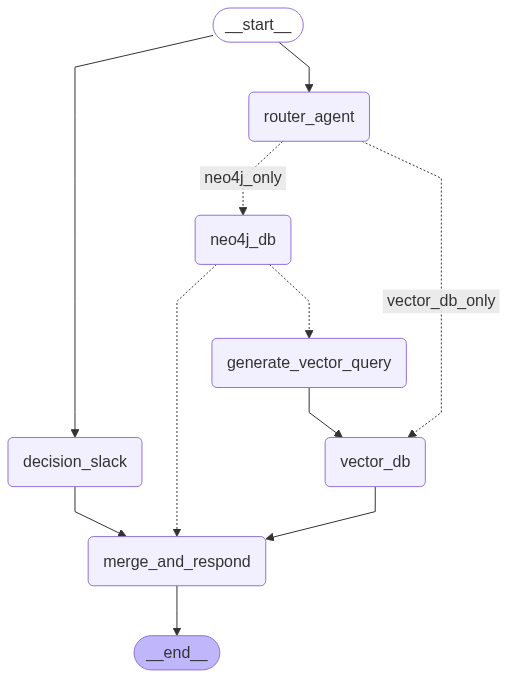

In [ ]:
# ==============================================================================
# 7. Graph 빌드 및 컴파일
# ==============================================================================

# Graph 빌더 초기화
builder = StateGraph(ChatbotState)

# 노드 추가
builder.add_node("router_agent", router_agent)
builder.add_node("decision_slack", decision_slack)
builder.add_node("neo4j_db", neo4j_db)
builder.add_node("generate_vector_query", generate_vector_query_node)
builder.add_node("vector_db", vector_db)
builder.add_node("merge_and_respond", merge_and_respond)

# 엣지 연결
builder.add_edge(START, "router_agent")
builder.add_edge(START, "decision_slack") # 슬랙 판단은 초기에 병렬로 수행

# 라우터 에이전트 이후의 조건부 분기
builder.add_conditional_edges(
    "router_agent",
    should_continue,
    {
        "sequential": "neo4j_db",
        "parallel": "neo4j_db", # 병렬도 일단 Neo4j부터 시작
        "neo4j_only": "neo4j_db",
        "vector_db_only": "vector_db",
    }
)

# 병렬 흐름 처리: 라우터에서 parallel이 결정되면 VectorDB도 함께 호출
# (LangGraph v0.2 이상에서는 add_conditional_edges의 반환값으로 리스트를 주어 바로 병렬처리 가능)
# 여기서는 간단하게 구현하기 위해, parallel일 때도 순차적으로 호출하되, 쿼리 생성 단계를 건너뜀
# 더 완벽한 병렬 처리를 원한다면 별도의 join 노드가 필요합니다.
# 이 코드에서는 parallel일 때 neo4j_db -> vector_db 순으로 실행됩니다.

# Neo4j 노드 이후의 조건부 분기
builder.add_conditional_edges(
    "neo4j_db",
    after_neo4j,
    {
        "generate_vector_query": "generate_vector_query",
        "merge_and_respond": "merge_and_respond"
    }
)

# 순차 흐름의 나머지 연결
builder.add_edge("generate_vector_query", "vector_db")

# VectorDB 노드와 슬랙 결정 노드는 최종 응답 생성 노드로 연결
builder.add_edge("vector_db", "merge_and_respond")
builder.add_edge("decision_slack", "merge_and_respond")

# 최종 응답 생성 후 종료
builder.add_edge("merge_and_respond", END)

# 그래프 컴파일
graph = builder.compile(checkpointer=memory)
graph

In [ ]:
# ==============================================================================
# 8. Graph 실행
# ==============================================================================
async def run_chatbot(query, thread_id):
    config = {"configurable": {"thread_id": thread_id}}
    async for event in graph.astream_events(
        {"question": query, "messages": []}, version="v1", config=config
    ):
        kind = event["event"]
        if kind == "on_chain_end":
            if event["name"] == "router_agent":
                print("\n--- 라우터 분석 완료 ---")
            elif event["name"] == "merge_and_respond":
                print("\n--- 최종 답변 생성 완료 ---")
                final_state = event['data']['output']
                print(f"\n최종 답변:\n{final_state['final_answer']}")
                if final_state['slack_response']:
                    print(f"\n슬랙 응답:\n{final_state['slack_response']}")

In [ ]:
# --- 테스트 실행 (우선 vector db 단독 흐름만 활성화) ---
async def main():
    # 테스트 1: 순차적 흐름 (환자 정보 -> 의학 정보)
    # query1 = "6세 여아 폐렴 환자가 받을 수술을 알려주고, 수술에 사용될 마취 약물에 대해 조사해서 백지연에게 slack으로 전송해줘."
    # print("="*20 + " 테스트 1: 순차(Sequential) " + "="*20)
    # await run_chatbot(query1, "thread-1")
    
    # print("\n\n" + "="*50 + "\n\n")

    # # 테스트 2: 병렬 흐름 (환자 정보 + 의학 정보)
    # query2 = "환자 ID 98765의 진단명을 알려주고, 케타민의 일반적인 부작용도 설명해줘."
    # print("="*20 + " 테스트 2: 병렬(Parallel) " + "="*20)
    # await run_chatbot(query2, "thread-2")

    # print("\n\n" + "="*50 + "\n\n")

    # # 테스트 3: Neo4j 단독 흐름
    # query3 = "환자 김민준의 나이와 성별을 알려줘."
    # print("="*20 + " 테스트 3: Neo4j Only " + "="*20)
    # await run_chatbot(query3, "thread-3")

    # print("\n\n" + "="*50 + "\n\n")

    # # 테스트 4: VectorDB 단독 흐름
    query4 = "Kasabach-Merritt Syndrome에 대해 조사해서 백지연에게 Slack으로 보내줘."
    print("="*20 + " 테스트 4: VectorDB Only " + "="*20)
    await run_chatbot(query4, "thread-4")

if __name__ == "__main__":
    pass

await main()

==================== 테스트 4: VectorDB Only ====================
---DECISION SLACK---
Slack Decision: Yes
---ROUTER AGENT---
Flow Type: vector_db_only
Neo4j Query: None
VectorDB Query: Kasabach-Merritt Syndrome에 대한 정보를 조사해 주세요. 이 증후군의 정의, 증상, 진단 방법, 치료 옵션 및 예후에 대한 정보를 포함해 주세요.
---ROUTING DECISION: vector_db_only---

--- 라우터 분석 완료 ---
---VECTOR DB RETRIEVER---
---MERGE AND RESPOND---
Final Answer: Kasabach-Merritt Syndrome (KMS)는 드문 혈관 질환으로, 주로 거대 혈관종(hemangioendothelioma)과 연관되어 발생합니다. 이 질환은 혈소판 감소증과 소비성 응고병증을 특징으로 하며, 이는 혈소판이 혈관종 내에서 소모되어 혈액 응고에 문제가 생기는 상태입니다. KMS는 생명을 위협할 수 있는 상태로, 적절한 치료가 필요합니다.

KMS의 주요 증상은 다음과 같습니다:
- 혈소판 감소증: 혈소판 수치가 비정상적으로 낮아져 출혈 위험이 증가합니다.
- 소비성 응고병증: 혈액 응고 인자가 소모되어 출혈 경향이 증가합니다.
- 혈관종: 피부나 내부 장기에 발생할 수 있는 혈관성 종양으로, 주로 청색-자주색의 국소적인 덩어리로 나타납니다.

치료 방법은 환자의 상태와 위험도에 따라 다르며, 다음과 같은 접근법이 사용될 수 있습니다:
- 고용량 코르티코스테로이드: 혈소판 수치를 개선하고 종양의 크기를 줄이는 데 도움이 될 수 있습니다.
- 시롤리무스: 면역억제제로, 혈관종의 성장을 억제하는 데 사용됩니다.
- 수술: 종양 제거를 통해 증상을 완화하고 합병증을 예방할 수 있습니다.
- 경동맥 화학색전술(TACE): 혈관종에 혈액 공급을 

 ;;; 아니 전송이 됐는데 뭔 전송을 실패했다는겨 ;; 이건 다시 수정해보겟숨다. 